In [76]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/HarritonResearchLab/sunnyhills/main/other/aesthetics/science.mplstyle')

In [10]:
def download(
    ticstr: str, 
    outdir: str = 'none', 
    logdir: str = 'none'): 
    
    ''' 
    Args:
        outdir: directory where lightcurves will be saved. If not set, data will not be saved. 
        ticstr: e.g., 'TIC 441420236'
        logdir: directory for log file
    Returns: 
        raw_list: list of light curve ojects that mean criteria but have not been processed (i.e. not detrended, normalized, or sigma-clipped) 
    '''

    import numpy as np 
    import lightkurve as lk 
    import os 
    import pickle 

    # get the light curve
    lcc = lk.search_lightcurve(ticstr).download_all()

    # select only the two-minute cadence SPOC-reduced data; convert to a list.
    # note that this conversion approach works for any LightCurveCollection
    # returned by lightkurve -- no need to hand-pick the right ones.  the exact
    # condition below says "if the interval is between 119 and 121 seconds,
    # take it".
    raw_list = [_l for _l in lcc
            if
            _l.meta['ORIGIN']=='NASA/Ames'
            and
            np.isclose(
                120,
                np.nanmedian(np.diff(_l.remove_outliers().time.value))*24*60*60,
                atol=1
            )
    ]

    raw_list = [_l for _l in raw_list if _l.meta['FLUX_ORIGIN']=='pdcsap_flux']
    
    new_raw_list = []

    for lc in raw_list: 
        time = lc.time.value
        flux = lc.pdcsap_flux.value
        qual = lc.quality.value

        # remove non-zero quality flags
        sel = (qual == 0)

        time = time[sel]
        flux = flux[sel]

        # normalize around 1
        flux /= np.nanmedian(flux)

        not_nan_mask = ~np.isnan(flux)

        time, flux = (time[not_nan_mask], flux[not_nan_mask])

        new_raw_list.append({'time':time, 'flux':flux})

    raw_list = new_raw_list 

    return raw_list

def preprocess(
    raw_list: list,
    ticstr: str = '',
    outdir: str = "none", 
    dtrdict: dict = {'method':'biweight',
                     'window_length':0.5,
                     'cval':5.0,
                     "break_tolerance":1.0}, 
    sigma_bounds: list = [10, 2]
    ):
    """
    Args:
        raw_list: raw list of light curves; see download() 
        outdir: directory where lightcurves will be saved. If not set, data will not be saved.  --> FIX!
        ticstr: e.g., 'TIC 441420236'.  
        dtrdict: dictionary with keys "window_length", "method", "cval",
                 "break_tolerance", or anything else needed by wotan's `flatten`
                 call.  These are documented at
                 https://wotan.readthedocs.io/en/latest/Usage.html 
        sigma_bounds: list of the lower and upper sigma bounds to use for post detrend sigma-clipping 
    Returns: 
        lc_list: list of light curve ojects that have met all criteria, been removed of outliers, normalized, and flattened. 
        trend_list: list of light curve objects with x = time, y = trend
        raw_list: list of the raw light curve objects 
    """

    import numpy as np 
    import lightkurve as lk 
    from wotan import flatten, slide_clip
    from astropy.stats import sigma_clip
    import pickle
    
    lc_list = [] # for detrended and "cleaned" light curves
    trend_list = []

    for lc in raw_list:

        time = lc['time']
        flux = lc['flux']

        # remove outliers before local window detrending
        clipped_flux = slide_clip(time, flux, window_length=0.5, low=3,
                                  high=2, method='mad', center='median')

        # see https://wotan.readthedocs.io/en/latest/Usage.html for other
        # possible options.
        flat_flux, trend_flux = flatten(
            time, clipped_flux, return_trend=True,
            method=dtrdict['method'],
            break_tolerance=dtrdict['break_tolerance'],
            window_length=dtrdict['window_length'],
            cval=dtrdict['cval']
        )

        flat_mean, flat_sigma = (np.nanmean(flat_flux), np.nanstd(flat_flux))

        #_, *bounds = sigma_clip(flat_flux, sigma_lower=10, sigma_upper=1, maxiters=1, masked=False, return_bounds=True) # okay flex LOL

        bounds = [flat_mean-sigma_bounds[0]*flat_sigma, flat_mean+sigma_bounds[1]*flat_sigma] # save these bounds to log file? 

        flat_mask = np.logical_and(flat_flux<bounds[1], flat_flux>bounds[0])

        flat_time = time[flat_mask]
        flat_flux = flat_flux[flat_mask]

        processed_lc = {'time':flat_time, "flux":flat_flux}
        trend_lc = {'time':time, 'flux':trend_flux}

        lc_list.append(processed_lc)
        trend_list.append(trend_lc)

    return lc_list, trend_list, raw_list 

In [62]:
#wasp-169
raw_list = download('TIC 386259537')
lc_list, trend_list, raw_lc = preprocess(raw_list, 'TIC 386259537')

#k2-3
#raw_list = download('TIC 173103335')
#lc_list, trend_list, raw_lc = preprocess(raw_list, 'TIC 173103335')
print(len(lc_list))

1


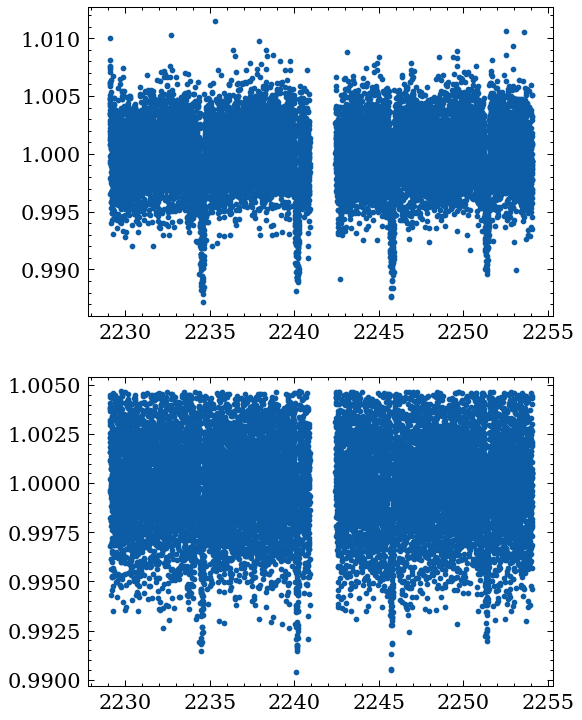

In [73]:
idx = 0
time = lc_list[idx]['time']
flux = lc_list[idx]['flux']

raw_time = raw_lc[idx]['time']
raw_flux = raw_lc[idx]['flux']

fig, axs = plt.subplots(2,1, figsize=(4,6))

axs[1].scatter(time, flux, s=3)

axs[0].scatter(raw_time, raw_flux, s=3)

In [66]:
def run_bls(lc_list, 
            bls_params: dict = {'min_per':0.5, 'max_per':15, 
                                'minimum_n_transit':2, 
                                'freq_factor':1,
                                'durations':[0.05, 0.06666666666666668, 
                                             0.08333333333333334, 0.1,
                                             0.11666666666666668, 
                                             0.13333333333333336,
                                             0.15000000000000002, 
                                             0.16666666666666669, 
                                             0.18333333333333335, 0.2], 
                                'objective':'snr'}, 
            compute_stats: bool = True): 

    '''
    args: 
        lc_list: light curve list
        bls_params: params for bls execution. see documentation 
        durations: list/array of durations to test
        periods: -
    '''

    from astropy.timeseries import BoxLeastSquares
    import numpy as np
    import matplotlib.pyplot as plt

    time = lc_list[0]['time']
    flux = lc_list[0]['flux']

    durations = np.array(bls_params['durations'])

    bls = BoxLeastSquares(t=time, y=flux)

    results = bls.autopower(durations, frequency_factor=bls_params['freq_factor'], 
                            minimum_period=bls_params['min_per'], 
                            maximum_period=bls_params['max_per'],
                            objective=bls_params['objective'])

    index = np.argmax(results.power)
    period = results.period[index]
    t0 = results.transit_time[index]
    duration = results.duration[index]
    
    in_transit = bls.transit_mask(time, period, 2*duration, t0)

    if compute_stats: 
        stats = bls.compute_stats(period, duration, t0)
        return results, bls, in_transit, stats

    else: 
        return results, bls, in_transit 

In [67]:
results, bls, in_transit, stats = run_bls(lc_list, compute_stats=True)

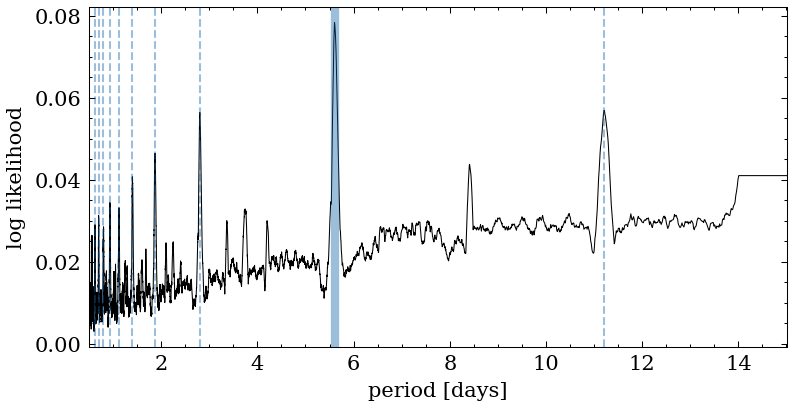

In [77]:
# Find the period of the peak
period = results.period[np.argmax(results.power)]

# Plot the periodogram
plt.rcParams["figure.dpi"] = 150
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(results.period, results.power, "k", lw=0.5)
ax.set_xlim(results.period.min(), results.period.max())
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood")

# Highlight the harmonics of the peak period
ax.axvline(period, alpha=0.4, lw=4)
for n in range(2, 10):
    ax.axvline(n*period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period / n, alpha=0.4, lw=1, linestyle="dashed")

plt.show()

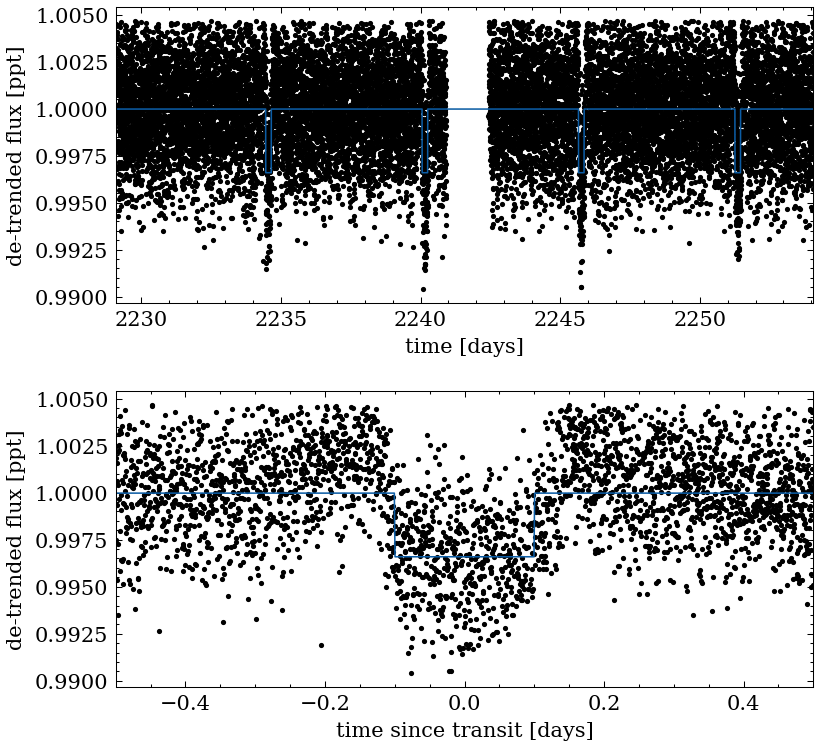

In [75]:
# Extract the parameters of the best-fit model
index = np.argmax(results.power)
period = results.period[index]
t0 = results.transit_time[index]
duration = results.duration[index]

fig, axes = plt.subplots(2, 1, figsize=(6, 6))
fig.subplots_adjust(hspace=0.3)

# Plot the light curve and best-fit model
ax = axes[0]
ax.plot(time, flux, ".k", ms=3)
x = np.linspace(min(time), max(time), 3*len(time))
f = bls.model(x, period, duration, t0)
ax.plot(x, f, lw=0.75)
ax.set_xlim(min(time), max(time))
#ax.set_ylim(-1.52, 0.4)
ax.set_xlabel("time [days]")
ax.set_ylabel("de-trended flux [ppt]")

# Plot the folded data points within 0.5 days of the transit time
ax = axes[1]
x = (time - t0 + 0.5*period) % period - 0.5*period
m = np.abs(x) < 0.5
ax.plot(x[m], flux[m], ".k", ms=3)

# Over-plot the best fit model

x = np.linspace(-0.5, 0.5, 1000)
f = bls.model(x + t0, period, duration, t0)
ax.plot(x, f, lw=0.75)
ax.set_xlim(-0.5, 0.5)
ax.set_xlabel("time since transit [days]")
ax.set_ylabel("de-trended flux [ppt]")

plt.show()

In [83]:
def iterative_bls_runner(lc_list, 
                     iterations: int=1, 
                     bls_params: dict = {'min_per':0.5, 'max_per':15, 
                                'minimum_n_transit':2, 
                                'freq_factor':1,
                                'durations':[0.05, 0.06666666666666668, 
                                             0.08333333333333334, 0.1,
                                             0.11666666666666668, 
                                             0.13333333333333336,
                                             0.15000000000000002, 
                                             0.16666666666666669, 
                                             0.18333333333333335, 0.2], 
                                'objective':'snr'}, 
                    compute_stats: bool = True): 

    '''
    Args:
        lc_list: lc_list, per usual 
        iterations: number of times to run the search, can be between 1 and 10 
        bls_params: per usual, dictionary of BLS parameters
        compute_stats: will be set to true by default? 

    Returns: 
        results_dict: dictionary of results from each iteration 
        models_dict: dicitonary of bls models from each iteration
        in_transits_dict: dictionary of in_transit arrays from each iteration
        stats_dict: dictionary of stats from each iteration if compute_stats==True
    '''

    from astropy.timeseries import BoxLeastSquares
    import numpy as np
    import matplotlib.pyplot as plt

    time = lc_list[0]['time']
    flux = lc_list[0]['flux']

    durations = np.array(bls_params['durations'])

    if iterations < 1:
        iterations = 1
    elif iterations > 10: 
        iterations = 10 

    results_dict = {} 
    models_dict = {} 
    in_transits_dict = {} 
    stats_dict = {} 

    iteration_names = ['first', 'second', 'third', 'fourth',
                       'fifth', 'sixth', 'seventh', 'eigth',
                       'ninth', 'tenth']

    for index in range(iterations):
        iter_name = iteration_names[index] 
        bls_model = BoxLeastSquares(t=time, y=flux)

        results = bls_model.autopower(durations, frequency_factor=bls_params['freq_factor'], 
                                minimum_period=bls_params['min_per'], 
                                maximum_period=bls_params['max_per'],
                                objective=bls_params['objective'])
        
        results_dict[iter_name] = results

        index = np.argmax(results.power)
        period = results.period[index]
        t0 = results.transit_time[index]
        duration = results.duration[index]
        
        in_transit = bls_model.transit_mask(time, period, 2*duration, t0)

        in_transits_dict[iter_name] = in_transit

        models_dict[iter_name] = bls_model

        if compute_stats: 
            stats = bls.compute_stats(period, duration, t0)
            stats_dict[iter_name] = stats

        time = time[~in_transit]
        flux = flux[~in_transit]

    if compute_stats: 
        stats = bls.compute_stats(period, duration, t0)
        stats_dict[iter_name] = stats
        return results_dict, models_dict, in_transits_dict, stats_dict

    else: 
        return results_dict, models_dict, in_transits_dict
        
    

In [84]:
results_dict, models_dict, in_transits_dict, stats_dict = iterative_bls_runner(lc_list, iterations=4)

In [86]:
print(in_transits_dict)

{'first': array([ True,  True,  True, ..., False, False, False]), 'second': array([ True,  True,  True, ..., False, False, False]), 'third': array([False, False, False, ..., False, False, False]), 'fourth': array([False, False, False, ..., False, False, False])}
